---
date: last-modified
---

# Authentication and access to data of the NASA Atmospheric Science Data Center in Amazon S3

## Summary

In this tutorial, you will learn how to authenticate with the ASDC data archive and obtain access to the data stored in Amazon S3 buckets. This will enable you to seamlessly perform operations such as listing, copying, and retrieving data from the ASDC archive using your preferred Amazon methods, such as Python boto3, the Amazon SDK, or AWS CLI.

Note: For most research and data users,
the details listed here will not be necessary,
as TEMPO files can be accessed from AWS S3 using the `earthaccess` Python library or via the NASA Earthdata Harmony API,
both of which simplify the process of managing credentials, and
searching for and retrieving data.
See the other how-to and tutorial notebooks for guidance on using these tools.

**Note:** Direct S3 access is exclusively accessible to users operating within the AWS environment, specifically in the us-west-2 region. For all other access, it is required to make HTTP requests for ASDC data.

## Prerequisites

- `boto3`
- `cartopy`
- `matplotlib`
- `netCDF4`
- `numpy`
- `s3fs`
- `xarray`

### Notebook Authors / Affiliation

Atmospheric Science Data Center (ASDC)

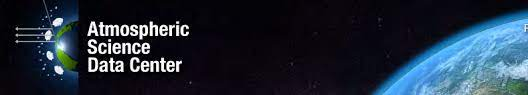


Imports necessary modules such as netrc, Popen, system, getpass, and os for a tutorial on achieving direct S3 access. The tutorial covers authentication with the ASDC data archive, utilizing Amazon S3 buckets, and will involve processes like handling credentials and system commands.

In [1]:
import os
from getpass import getpass
from netrc import netrc
from platform import system
from subprocess import Popen

In [2]:
urs = "urs.earthdata.nasa.gov"  # Earthdata URL endpoint for authentication
prompts = ["Enter NASA Earthdata Login Username: ", "Enter NASA Earthdata Login Password: "]

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system() == "Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen(
        "touch {0}{2} | echo machine {1} >> {0}{2}".format(homeDir + os.sep, urs, netrc_name),
        shell=True,
    )
    Popen(
        "echo login {} >> {}{}".format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name),
        shell=True,
    )
    Popen(
        "echo 'password {} '>> {}{}".format(
            getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name
        ),
        shell=True,
    )
    # Set restrictive permissions
    Popen("chmod 0600 {0}{1}".format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen("echo machine {1} >> {0}{2}".format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen(
        "echo login {} >> {}{}".format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name),
        shell=True,
    )
    Popen(
        "echo 'password {} '>> {}{}".format(
            getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name
        ),
        shell=True,
    )

In [3]:
#!ls -al ~/

In [4]:
import boto3
import requests
import xarray as xr

%matplotlib inline

## Get Temporary AWS Credentials for Access

Note: AWS Credentials will expire after one hour

S3 serves as an 'object store' on AWS for cloud processing. To enable direct S3 access, temporary credentials provided by NASA must be passed to AWS, facilitating interaction with S3 objects within applicable Earthdata Cloud buckets. It's important to note that these temporary credentials remain valid for only one hour. To obtain them, a netrc file is required. Utilize NASA Earthdata Authentication to generate a netrc file in your home directory.  Use the [NASA Earthdata Authentication](https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb) to create a netrc file in your home directory. (Note: A NASA Earthdata Login is essential for accessing data from the NASA Earthdata system. Register and manage your Earthdata Login account at https://urs.earthdata.nasa.gov. This account is free to create and requires only a brief setup time.)

While the presented credentials are for ASDC, distinct credentials are necessary for accessing data from other NASA DAACs.

In [5]:
s3_cred_endpoint = "https://data.asdc.earthdata.nasa.gov/s3credentials"

Create a function to make a request to an endpoint for temporary credentials.

In [6]:
def get_temp_creds():
    temp_creds_url = s3_cred_endpoint
    return requests.get(temp_creds_url).json()

In [7]:
temp_creds_req = get_temp_creds()
# temp_creds_req                      # !!! Removing the # on this line will print your temporary S3 credentials.

### List all datasets available using boto3

In [8]:
s3_client = boto3.client(
    "s3",
    aws_access_key_id=temp_creds_req["accessKeyId"],
    aws_secret_access_key=temp_creds_req["secretAccessKey"],
    aws_session_token=temp_creds_req["sessionToken"],
)

In [9]:
# If you want to view a list of the S3 bucket content

# s3_client.list_objects(Bucket="asdc-prod-protected", Prefix="TEMPO/TEMPO_O3TOT_L3_V03/")
# s3_client.list_objects(Bucket="asdc-prod-protected", Prefix="TEMPO/TEMPO_HCHO-PROXY_L2_V03/")

### Download a specific file within the cloud, open and plot a variable from it

In [10]:
s3_client.download_file(
    "asdc-prod-protected",
    "TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc",
    "TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc",
)

In [11]:
results = s3_client.download_file(
    "asdc-prod-protected",
    "TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc",
    "TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc",
)

In [12]:
ds = xr.open_dataset("TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc")
ds

<xarray.Dataset> Size: 91MB
Dimensions:    (longitude: 7750, latitude: 2950, time: 1)
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2023-08-02T15:13:07.138977024
Data variables:
    weight     (latitude, longitude) float32 91MB ...
Attributes: (12/40)
    history:                          2024-06-03T15:27:12Z: L2_regrid -v /tem...
    scan_num:                         1
    time_coverage_start:              2023-08-02T15:12:49Z
    time_coverage_end:                2023-08-02T16:14:59Z
    time_coverage_start_since_epoch:  1375024387.138977
    time_coverage_end_since_epoch:    1375028117.3767278
    ...                               ...
    title:                            TEMPO Level 3 total ozone product
    collection_shortname:             TEMPO_O3TOT_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>ATMOSPHERIC CH...
    summary:                          Total ozone Level 3 files provide ozone...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [13]:
# print(ds.keys())


In [14]:
# all_results_stored = [f.result() for f in ds]
# print(f"Number of result files: {len(all_results_stored)}")

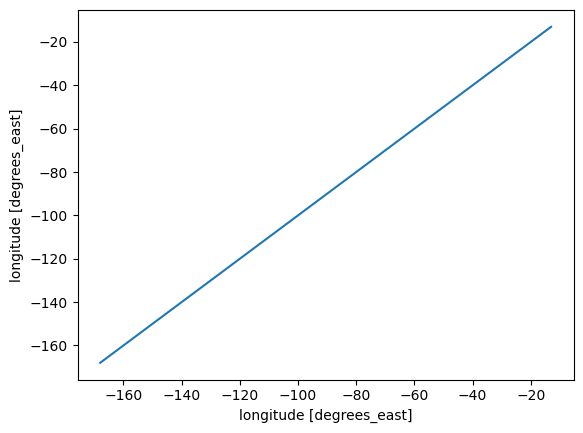

In [15]:
ds.longitude.plot()

### Set up an `s3fs` session for Direct Access without downloading within the cloud
`s3fs` sessions serve the purpose of facilitating authenticated access to S3 buckets, enabling conventional file-system style operations. In the following steps, we establish a session by providing the temporary credentials obtained from our credentials endpoint, and subsequently identify the S3 paths leading to the desired data.

In [16]:
import s3fs
import os

os.environ["AWS_ACCESS_KEY_ID"] = temp_creds_req["accessKeyId"]
os.environ["AWS_SECRET_ACCESS_KEY"] = temp_creds_req["secretAccessKey"]
os.environ["AWS_SESSION_TOKEN"] = temp_creds_req["sessionToken"]

s3 = s3fs.S3FileSystem(anon=False)

s3path = "s3://asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/*.nc"
remote_files = s3.glob(s3path)

In [17]:
import os

current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /home/jovyan/ASDC_Data_and_User_Services/TEMPO


This code utilizes the s3fs library to establish authenticated access to an S3 bucket and download files matching a specified pattern. Key steps include setting AWS credentials, initializing the S3 filesystem, defining the S3 path pattern, listing matching files, and downloading them to a specified local directory. The script concludes by printing the number of downloaded files and the local directory path.

In [18]:
import s3fs

# Set AWS credentials
os.environ["AWS_ACCESS_KEY_ID"] = temp_creds_req["accessKeyId"]
os.environ["AWS_SECRET_ACCESS_KEY"] = temp_creds_req["secretAccessKey"]
os.environ["AWS_SESSION_TOKEN"] = temp_creds_req["sessionToken"]

# Initialize S3 filesystem
s3 = s3fs.S3FileSystem(anon=False)

# Specify the S3 path pattern
s3path = "s3://asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/*.nc"
# List matching files
remote_files = s3.glob(s3path)

# Download files
local_directory = "/home/jovyan"  # Specify your local directory here

for remote_file in remote_files:
    remote_file_name = remote_file.split("/")[-1]  # Extract file name from the S3 path
    local_file_path = os.path.join(local_directory, remote_file_name)  # Local file path
    with s3.open(remote_file, "rb") as remote_data:
        with open(local_file_path, "wb") as local_file:
            local_file.write(remote_data.read())

print(f"Downloaded {len(remote_files)} files to {local_directory}")

Downloaded 6 files to /home/jovyan


In [19]:
# Files list
remote_files

['asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T161520Z_S002.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T171751Z_S003.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T182022Z_S004.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T192253Z_S005.nc',
 'asdc-prod-protected/TEMPO/TEMPO_O3TOT_L3_V03/2023.08.02/TEMPO_O3TOT_L3_V03_20230802T202524Z_S006.nc']

In [20]:
ds = xr.open_dataset("TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc")
ds

<xarray.Dataset> Size: 91MB
Dimensions:    (longitude: 7750, latitude: 2950, time: 1)
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2023-08-02T15:13:07.138977024
Data variables:
    weight     (latitude, longitude) float32 91MB ...
Attributes: (12/40)
    history:                          2024-06-03T15:27:12Z: L2_regrid -v /tem...
    scan_num:                         1
    time_coverage_start:              2023-08-02T15:12:49Z
    time_coverage_end:                2023-08-02T16:14:59Z
    time_coverage_start_since_epoch:  1375024387.138977
    time_coverage_end_since_epoch:    1375028117.3767278
    ...                               ...
    title:                            TEMPO Level 3 total ozone product
    collection_shortname:             TEMPO_O3TOT_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>ATMOSPHERIC CH...
    summary:                          Total ozone Level 3 files provide ozone...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [22]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

This Jupyter notebook code processes TEMPO ozone data stored in NetCDF files, creating individual Cartopy plots for each granule. Key steps include reading the data, checking for data validity, and generating scatter plots with ozone concentrations. The resulting plots are saved as PNG files in the specified directory. The script provides informative messages about the number of granules found and their paths, ensuring a user-friendly experience.

The following code utilizes libraries like glob, os, sys, numpy, netCDF4, and matplotlib to process TEMPO ozone data. It reads granule files, checks data integrity, and generates Cartopy plots for each granule. The script is currently set to process the first granule only and contains commented-out sections that may require adjustment for specific use cases.

In [23]:
xr.open_dataset("/home/jovyan/TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc")

<xarray.Dataset> Size: 91MB
Dimensions:    (longitude: 7750, latitude: 2950, time: 1)
Coordinates:
  * longitude  (longitude) float32 31kB -168.0 -168.0 -167.9 ... -13.03 -13.01
  * latitude   (latitude) float32 12kB 14.01 14.03 14.05 ... 72.95 72.97 72.99
  * time       (time) datetime64[ns] 8B 2023-08-02T15:13:07.138977024
Data variables:
    weight     (latitude, longitude) float32 91MB ...
Attributes: (12/40)
    history:                          2024-06-03T15:27:12Z: L2_regrid -v /tem...
    scan_num:                         1
    time_coverage_start:              2023-08-02T15:12:49Z
    time_coverage_end:                2023-08-02T16:14:59Z
    time_coverage_start_since_epoch:  1375024387.138977
    time_coverage_end_since_epoch:    1375028117.3767278
    ...                               ...
    title:                            TEMPO Level 3 total ozone product
    collection_shortname:             TEMPO_O3TOT_L3
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>ATMOSPHERIC CH...
    summary:                          Total ozone Level 3 files provide ozone...
    coremetadata:                     \nGROUP                  = INVENTORYMET...

In [24]:
# Generates png files for timelapse. This steps needs powerful machine with more than 32GB RAM
import glob
import os
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def read_TEMPO_O3TOT_L3(fn):
    ds = nc.Dataset(fn)
    lat = ds.variables["latitude"][:]
    lon = ds.variables["longitude"][:]

    prod = ds.groups["product"]
    o3var = prod.variables["column_amount_o3"]
    fv = o3var.getncattr("_FillValue")
    o3tot = o3var[:]
    return lat, lon, o3tot, fv


nlat0 = 2950
nlon0 = 7750
path_L3_O3 = "/home/jovyan/"

year = "2023"
month = "8"
granules = glob.glob(path_L3_O3 + "/TEMPO_O3TOT_L3_V03*.nc")

granules.sort()
num_granules = len(granules)

print(num_granules, " granules were found for yyyymm " + year + month + ", here are the first few:")
for granule in granules[0 : min(num_granules, 20)]:
    print(granule)

latc, lonc, o3totc, fv = read_TEMPO_O3TOT_L3(os.path.join(path_L3_O3, granules[0]))

lon_grid, lat_grid = np.meshgrid(lonc, latc)

6  granules were found for yyyymm 20238, here are the first few:
/home/jovyan/TEMPO_O3TOT_L3_V03_20230802T151249Z_S001.nc
/home/jovyan/TEMPO_O3TOT_L3_V03_20230802T161520Z_S002.nc
/home/jovyan/TEMPO_O3TOT_L3_V03_20230802T171751Z_S003.nc
/home/jovyan/TEMPO_O3TOT_L3_V03_20230802T182022Z_S004.nc
/home/jovyan/TEMPO_O3TOT_L3_V03_20230802T192253Z_S005.nc
/home/jovyan/TEMPO_O3TOT_L3_V03_20230802T202524Z_S006.nc


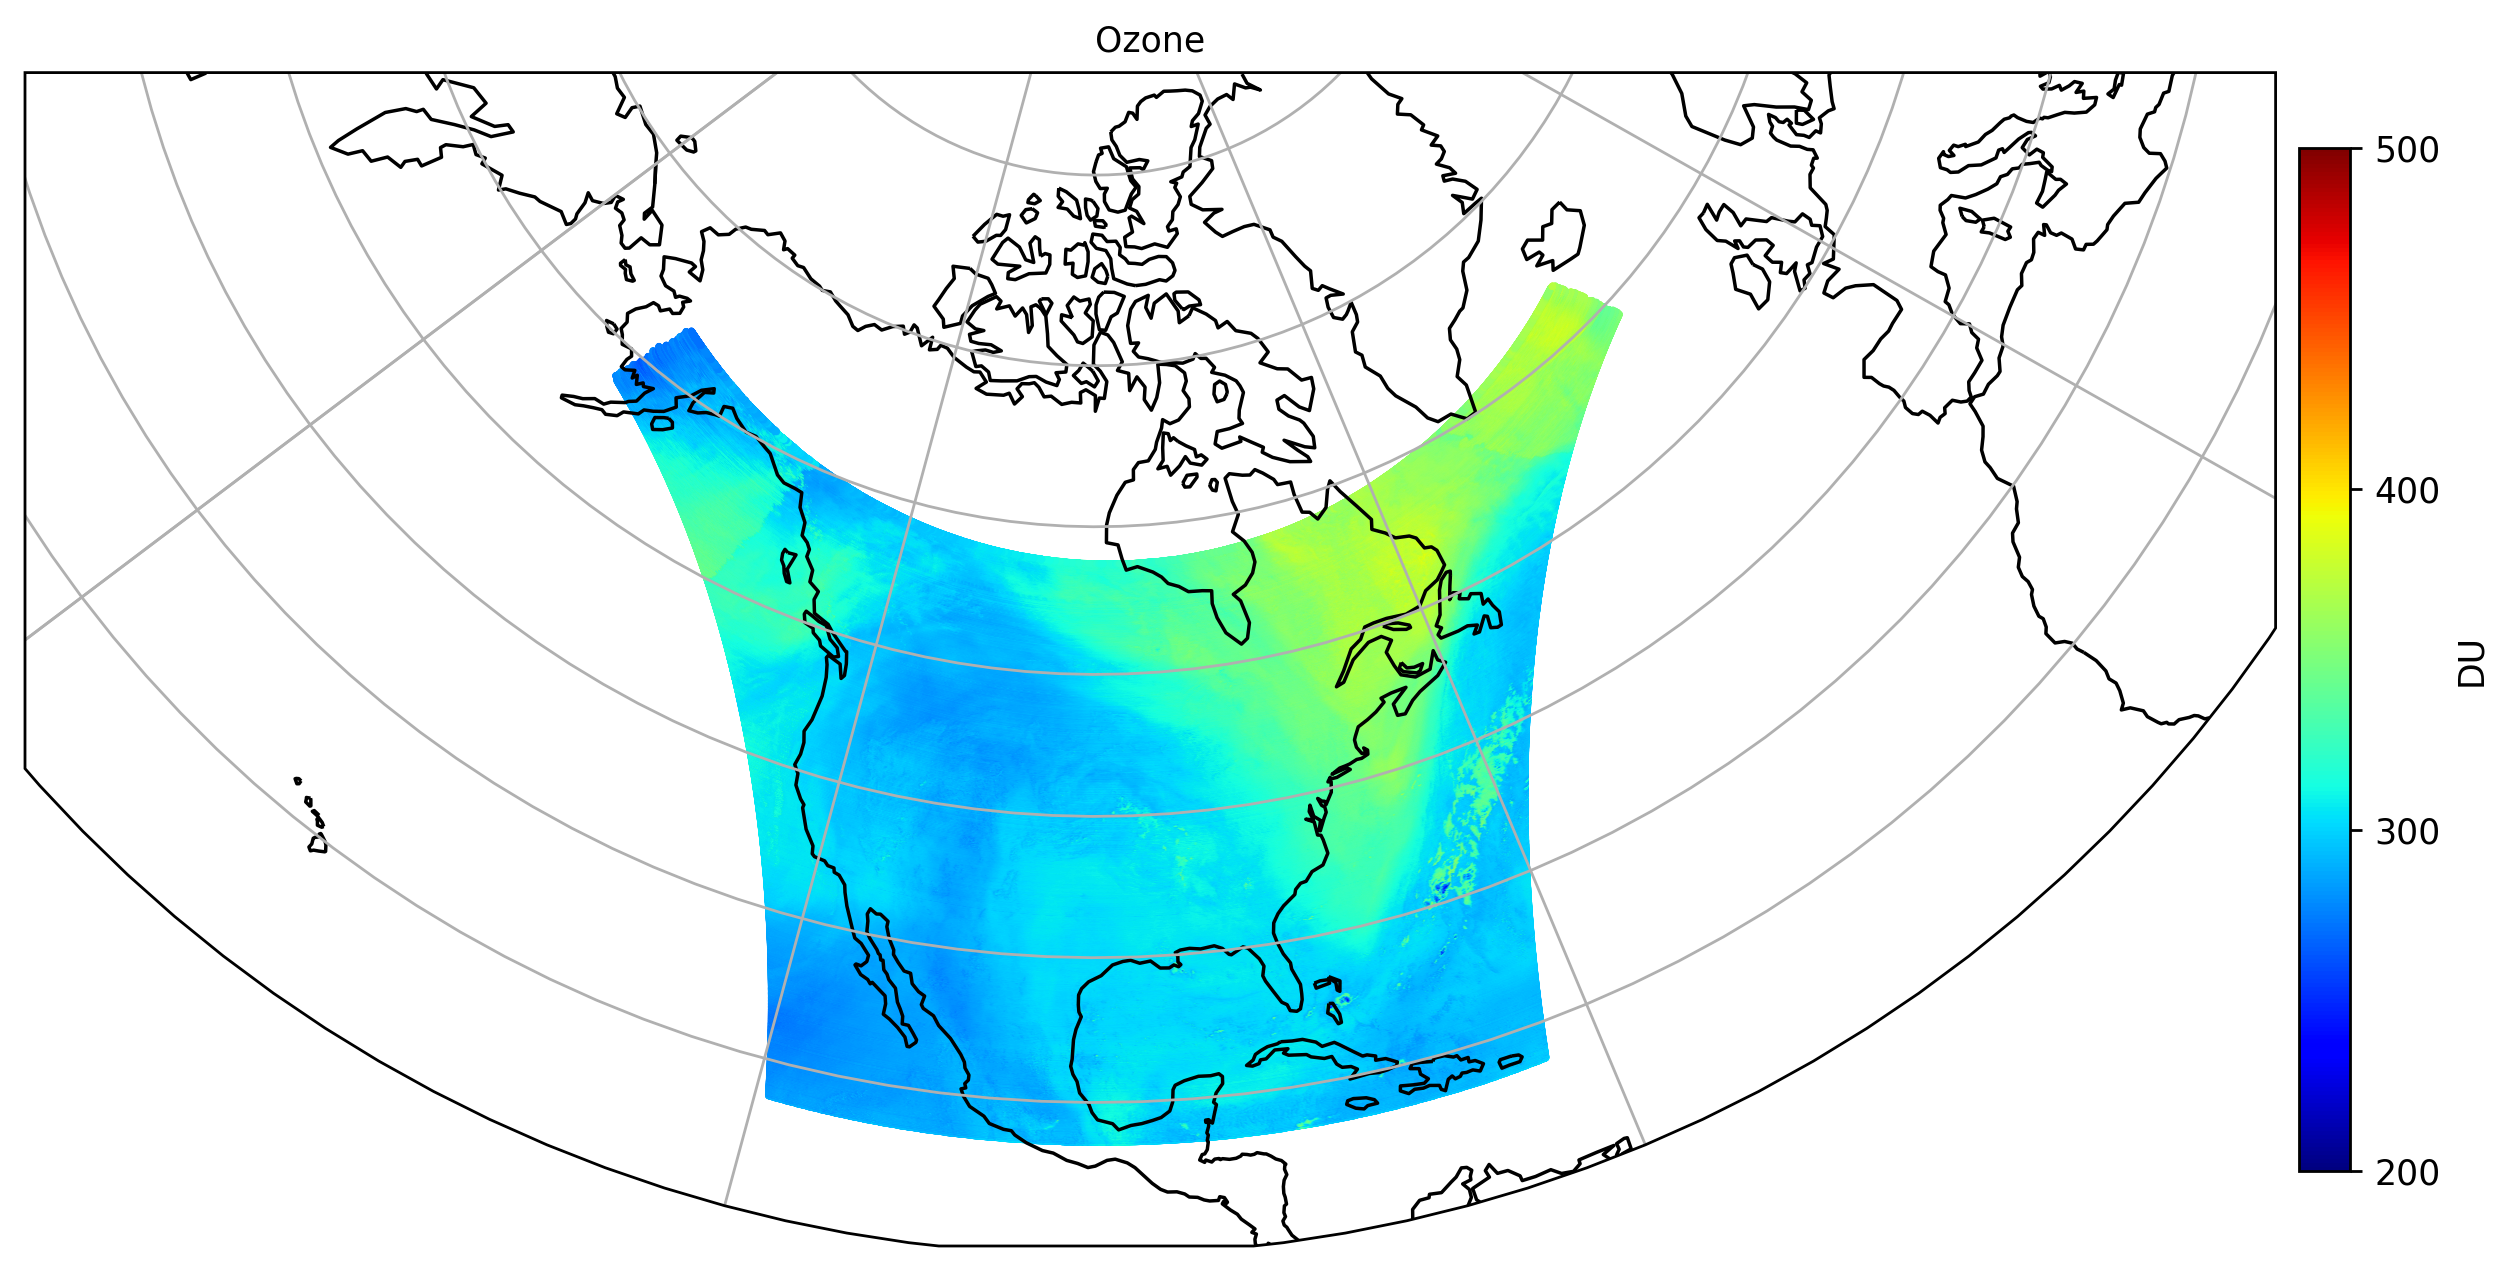

In [25]:
# Generates png file.

proj = ccrs.LambertConformal(
    central_longitude=-96.0,
    central_latitude=39.0,
    false_easting=0.0,
    false_northing=0.0,
    standard_parallels=(33, 45),
    globe=None,
    cutoff=10,
)

fig, ax = plt.subplots(figsize=(12, 9.5), dpi=250, subplot_kw={"projection": proj})
ax.coastlines(resolution="110m", color="black", linewidth=1)

im1 = ax.scatter(
    lon_grid,
    lat_grid,
    c=o3totc,
    s=1,
    cmap="jet",
    vmin=200.0,
    vmax=500.0,
    transform=ccrs.PlateCarree(),
)

gl = ax.gridlines()
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cb1 = plt.colorbar(im1, ticks=[200, 300, 400, 500, 600], fraction=0.022, pad=0.01)
cb1.set_label("DU", fontsize=10)

ax.set_title("Ozone", size=10)

plt.show()